In [ ]:
#  Imports
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU error: {e}")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [ ]:
# Load data
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
val_dataset = VesselMNIST3D(split='val', size=28, download=True)
test_dataset = VesselMNIST3D(split='test', size=28, download=True)

trainx = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
trainy = np.array([train_dataset[i][1][0] for i in range(len(train_dataset))])

valx = np.array([val_dataset[i][0] for i in range(len(val_dataset))])
valy = np.array([val_dataset[i][1][0] for i in range(len(val_dataset))])

testx = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
testy = np.array([test_dataset[i][1][0] for i in range(len(test_dataset))])

print(f"Train X shape: {trainx.shape}, Train y shape: {trainy.shape}")
print(f"Val X shape: {valx.shape}, Val y shape: {valy.shape}")
print(f"Test X shape: {testx.shape}, Test y shape: {testy.shape}")
print(f"Unique train labels: {np.unique(trainy)}")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")
print(f"\nRAW data range: [{trainx.min():.3f}, {trainx.max():.3f}]")
print("NOTE: Data is already normalized to [0,1] - DO NOT divide by 255!")

Train X shape: (1335, 1, 28, 28, 28), Train y shape: (1335,)
Val X shape: (191, 1, 28, 28, 28), Val y shape: (191,)
Test X shape: (382, 1, 28, 28, 28), Test y shape: (382,)
Unique train labels: [0 1]
Class 0: 1185, Class 1: 150

RAW data range: [0.000, 1.000]
NOTE: Data is already normalized to [0,1] - DO NOT divide by 255!


In [ ]:
# Aggressive augmentation for minority class
from scipy.ndimage import rotate, shift, zoom

print("Original class distribution:")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")

def augment_3d(volume):
    """More aggressive augmentations for 3D volumes"""
    aug = volume.copy()
    
    # Random rotation (larger angle)
    if np.random.rand() > 0.3:
        angle = np.random.uniform(-20, 20)
        axes_list = [(1,2), (1,3), (2,3)]
        axes = axes_list[np.random.randint(0, 3)]
        aug = rotate(aug, angle, axes=axes, reshape=False, mode='nearest', order=1)
    
    # Random flip along multiple axes
    for axis in [1, 2, 3]:
        if np.random.rand() > 0.5:
            aug = np.flip(aug, axis=axis).copy()
    
    # Small shift
    if np.random.rand() > 0.3:
        shift_vals = [0] + [np.random.randint(-3, 4) for _ in range(3)]
        aug = shift(aug, shift_vals, mode='nearest', order=0)
    
    # Random noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.02, aug.shape)
        aug = np.clip(aug + noise, 0, 1)
    
    # Random contrast adjustment
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        aug = np.clip(aug * factor, 0, 1)
    
    return aug

# Find class 1 samples and balance to equal numbers
class1_idx = np.where(trainy == 1)[0]
class0_count = np.sum(trainy == 0)
class1_count = len(class1_idx)

# Oversample to match class 0
target_class1 = class0_count  # Equal to majority class
augmentations_needed = target_class1 - class1_count
augs_per_sample = max(1, augmentations_needed // class1_count + 1)

print(f"\nAugmenting {class1_count} Class 1 samples")
print(f"Creating ~{augs_per_sample} augmentations per sample")

augmented_x = []
augmented_y = []

for idx in class1_idx:
    for _ in range(augs_per_sample):
        if len(augmented_x) >= augmentations_needed:
            break
        aug_vol = augment_3d(trainx[idx])
        augmented_x.append(aug_vol)
        augmented_y.append(1)

augmented_x = np.array(augmented_x)
augmented_y = np.array(augmented_y)

print(f"Generated {len(augmented_x)} augmented samples")

# Combine original and augmented
trainx = np.concatenate([trainx, augmented_x], axis=0)
trainy = np.concatenate([trainy, augmented_y], axis=0)

# Shuffle
shuffle_idx = np.random.permutation(len(trainx))
trainx = trainx[shuffle_idx]
trainy = trainy[shuffle_idx]

print(f"\nNew class distribution:")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")
print(f"Ratio: {np.sum(trainy==1) / np.sum(trainy==0):.3f}")
print(f"Final training set size: {len(trainx)}")

Original class distribution:
Class 0: 1185, Class 1: 150

Augmenting 150 Class 1 samples
Creating ~7 augmentations per sample
Generated 1035 augmented samples

New class distribution:
Class 0: 1185, Class 1: 1185
Ratio: 1.000
Final training set size: 2370


In [ ]:
#  Proper normalization 
# Just transpose to channels_last format
trainx = trainx.transpose(0, 2, 3, 4, 1).astype(np.float32)
valx = valx.transpose(0, 2, 3, 4, 1).astype(np.float32)
testx = testx.transpose(0, 2, 3, 4, 1).astype(np.float32)

trainy = trainy.astype(np.float32)
valy = valy.astype(np.float32)
testy = testy.astype(np.float32)

print(f"Final train X shape: {trainx.shape}")
print(f"Final train y shape: {trainy.shape}")
print(f"Data range: [{trainx.min():.3f}, {trainx.max():.3f}]")
print("\n✓ Data range is correct [0, 1]!")

Final train X shape: (2370, 28, 28, 28, 1)
Final train y shape: (2370,)
Data range: [0.000, 1.000]

✓ Data range is correct [0, 1]!


In [ ]:
#  Improved model architecture with BatchNorm and residual-like connections
from tensorflow.keras import regularizers

def build_improved_model():
    inputs = layers.Input(shape=(28, 28, 28, 1))
    
    # Block 1
    x = layers.Conv3D(32, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(32, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Block 2
    x = layers.Conv3D(64, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(64, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Block 3
    x = layers.Conv3D(128, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(128, (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Dense layers
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_improved_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 28, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 28, 28, 28, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 28, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 28, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 28, 28, 28, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 28, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 28, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 14, 14, 14, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 14, 14, 14, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 7, 7, 7, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 7, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 7, 7, 7, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 7, 128)   │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 868,769 (3.31 MB)

 Trainable params: 867,745 (3.31 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
#  Focal Loss for imbalanced classification
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal loss for imbalanced classification.
    alpha: weight for positive class (increase for minority class)
    gamma: focusing parameter (higher = more focus on hard examples)
    """
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Cross entropy
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        
        # Focal weights
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = K.pow(1 - p_t, gamma)
        
        # Alpha weights
        alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        return K.mean(alpha_weight * focal_weight * cross_entropy)
    
    return loss

In [ ]:
# Compile with focal loss and lower learning rate
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR for stability
    loss=focal_loss(gamma=2.0, alpha=0.75),  # Focal loss with high weight for Class 1
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
#  Class weights (additional boost for minority class)
class_counts = np.bincount(trainy.astype(int))
total = len(trainy)

# Compute balanced weights
weight_0 = total / (2 * class_counts[0])
weight_1 = total / (2 * class_counts[1])

# Give extra weight to minority class
class_weight = {
    0: weight_0,
    1: weight_1 * 1.5  # Extra boost for minority
}

print(f"Class counts: Class 0={class_counts[0]}, Class 1={class_counts[1]}")
print(f"Class weights: {class_weight}")

Class counts: Class 0=1185, Class 1=1185
Class weights: {0: np.float64(1.0), 1: np.float64(1.5)}


In [ ]:
#  Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    mode='max'
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_improved.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

In [ ]:
#  Train
print("Starting training...")
history = model.fit(
    trainx, trainy,
    validation_data=(valx, valy),
    epochs=80,
    batch_size=16,  # Smaller batch for better gradient estimates
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Starting training...
Epoch 1/80
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6130 - auc: 0.6954 - loss: 0.3049 - precision: 0.6221 - recall: 0.4655

149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.6886 - auc: 0.7764 - loss: 0.2199 - precision: 0.7083 - recall: 0.6414 - val_accuracy: 0.1152 - val_auc: 0.7937 - val_loss: 0.3412 - val_precision: 0.1152 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.7637 - auc: 0.8676 - loss: 0.1264 - precision: 0.7306 - recall: 0.8354 - val_accuracy: 0.1152 - val_auc: 0.7858 - val_loss: 0.4051 - val_precision: 0.1152 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.7565 - auc: 0.8774 - loss: 0.1162 - precision: 0.7074 - recall: 0.8751 - val_accuracy: 0.1152 - val_auc: 0.7811 - val_loss: 0.8856 - val_precision: 0.1152 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.7983 - auc: 0.9218 - loss: 0.0968 - precision: 0.7446 - recall: 0.9080 - val_accuracy: 0.7330 - val_auc: 0.3896 - val_loss:

149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.8350 - auc: 0.9477 - loss: 0.0737 - precision: 0.7832 - recall: 0.9266 - val_accuracy: 0.8377 - val_auc: 0.8441 - val_loss: 0.0867 - val_precision: 0.3846 - val_recall: 0.6818 - learning_rate: 2.5000e-04
Epoch 11/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.8553 - auc: 0.9661 - loss: 0.0652 - precision: 0.7956 - recall: 0.9561 - val_accuracy: 0.8010 - val_auc: 0.8341 - val_loss: 0.0782 - val_precision: 0.3462 - val_recall: 0.8182 - learning_rate: 2.5000e-04
Epoch 12/80
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8457 - auc: 0.9634 - loss: 0.0652 - precision: 0.7796 - recall: 0.9581

149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.8612 - auc: 0.9685 - loss: 0.0626 - precision: 0.8010 - recall: 0.9612 - val_accuracy: 0.4555 - val_auc: 0.8804 - val_loss: 0.1334 - val_precision: 0.1694 - val_recall: 0.9545 - learning_rate: 2.5000e-04
Epoch 13/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.8080 - auc: 0.9310 - loss: 0.0788 - precision: 0.7563 - recall: 0.9089 - val_accuracy: 0.8848 - val_auc: 0.7860 - val_loss: 0.4142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 14/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.8350 - auc: 0.9601 - loss: 0.0653 - precision: 0.7719 - recall: 0.9511 - val_accuracy: 0.7801 - val_auc: 0.8320 - val_loss: 0.0804 - val_precision: 0.3276 - val_recall: 0.8636 - learning_rate: 2.5000e-04
Epoch 15/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - accuracy: 0.8456 - auc: 0.9616 - loss: 0.0641 - precision: 0.7850 - recall: 0.9519 - val_accuracy: 0.6335 - val_auc: 0.8133 

149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.9443 - auc: 0.9940 - loss: 0.0358 - precision: 0.9110 - recall: 0.9848 - val_accuracy: 0.5654 - val_auc: 0.8885 - val_loss: 0.1030 - val_precision: 0.1919 - val_recall: 0.8636 - learning_rate: 6.2500e-05
Epoch 30/80
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9496 - auc: 0.9945 - loss: 0.0349 - precision: 0.9170 - recall: 0.9871

149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9511 - auc: 0.9947 - loss: 0.0345 - precision: 0.9205 - recall: 0.9873 - val_accuracy: 0.6283 - val_auc: 0.8958 - val_loss: 0.0897 - val_precision: 0.2184 - val_recall: 0.8636 - learning_rate: 6.2500e-05
Epoch 31/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step - accuracy: 0.9536 - auc: 0.9949 - loss: 0.0337 - precision: 0.9222 - recall: 0.9907 - val_accuracy: 0.7958 - val_auc: 0.8885 - val_loss: 0.0616 - val_precision: 0.3396 - val_recall: 0.8182 - learning_rate: 6.2500e-05
Epoch 32/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9586 - auc: 0.9952 - loss: 0.0330 - precision: 0.9310 - recall: 0.9907 - val_accuracy: 0.7592 - val_auc: 0.8662 - val_loss: 0.0701 - val_precision: 0.3065 - val_recall: 0.8636 - learning_rate: 6.2500e-05
Epoch 33/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.9595 - auc: 0.9956 - loss: 0.0323 - precision: 0.9318 - recall: 0.9916 - val_accuracy: 0.6597 - val_auc: 0.8854 - val_lo

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9654 - auc: 0.9979 - loss: 0.0279 - precision: 0.9430 - recall: 0.9907 - val_accuracy: 0.5445 - val_auc: 0.9012 - val_loss: 0.1387 - val_precision: 0.1963 - val_recall: 0.9545 - learning_rate: 3.1250e-05
Epoch 42/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9671 - auc: 0.9978 - loss: 0.0278 - precision: 0.9424 - recall: 0.9949 - val_accuracy: 0.6911 - val_auc: 0.8958 - val_loss: 0.0935 - val_precision: 0.2533 - val_recall: 0.8636 - learning_rate: 3.1250e-05
Epoch 43/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9679 - auc: 0.9973 - loss: 0.0282 - precision: 0.9468 - recall: 0.9916 - val_accuracy: 0.6545 - val_auc: 0.8784 - val_loss: 0.1021 - val_precision: 0.2317 - val_recall: 0.8636 - learning_rate: 3.1250e-05
Epoch 44/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.9705 - auc: 0.9981 - loss: 0.0271 - precision: 0.9485 - recall: 0.9949 - val_accuracy: 0.7906 - val_auc: 0.8989 - val_lo

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9819 - auc: 0.9993 - loss: 0.0238 - precision: 0.9665 - recall: 0.9983 - val_accuracy: 0.7749 - val_auc: 0.9069 - val_loss: 0.0743 - val_precision: 0.3220 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 55/80
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9761 - auc: 0.9985 - loss: 0.0253 - precision: 0.9587 - recall: 0.9940

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9776 - auc: 0.9988 - loss: 0.0247 - precision: 0.9624 - recall: 0.9941 - val_accuracy: 0.7696 - val_auc: 0.9072 - val_loss: 0.0726 - val_precision: 0.3167 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 56/80
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9789 - auc: 0.9986 - loss: 0.0245 - precision: 0.9592 - recall: 0.9997

149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.9844 - auc: 0.9993 - loss: 0.0234 - precision: 0.9713 - recall: 0.9983 - val_accuracy: 0.7592 - val_auc: 0.9094 - val_loss: 0.0835 - val_precision: 0.3065 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 57/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9806 - auc: 0.9982 - loss: 0.0245 - precision: 0.9649 - recall: 0.9975 - val_accuracy: 0.8220 - val_auc: 0.9075 - val_loss: 0.0640 - val_precision: 0.3696 - val_recall: 0.7727 - learning_rate: 1.5625e-05
Epoch 58/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9806 - auc: 0.9992 - loss: 0.0235 - precision: 0.9664 - recall: 0.9958 - val_accuracy: 0.7120 - val_auc: 0.9060 - val_loss: 0.0904 - val_precision: 0.2676 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 59/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9827 - auc: 0.9993 - loss: 0.0232 - precision: 0.9696 - recall: 0.9966 - val_accuracy: 0.7853 - val_auc: 0.9080 - val_lo

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9840 - auc: 0.9993 - loss: 0.0230 - precision: 0.9720 - recall: 0.9966 - val_accuracy: 0.8063 - val_auc: 0.9096 - val_loss: 0.0678 - val_precision: 0.3585 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 61/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.9831 - auc: 0.9992 - loss: 0.0231 - precision: 0.9696 - recall: 0.9975 - val_accuracy: 0.8586 - val_auc: 0.9022 - val_loss: 0.0636 - val_precision: 0.4359 - val_recall: 0.7727 - learning_rate: 1.5625e-05
Epoch 62/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9840 - auc: 0.9992 - loss: 0.0230 - precision: 0.9720 - recall: 0.9966 - val_accuracy: 0.8168 - val_auc: 0.9056 - val_loss: 0.0675 - val_precision: 0.3725 - val_recall: 0.8636 - learning_rate: 1.5625e-05
Epoch 63/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9814 - auc: 0.9992 - loss: 0.0230 - precision: 0.9665 - recall: 0.9975 - val_accuracy: 0.8534 - val_auc: 0.9024 - val_lo

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9848 - auc: 0.9992 - loss: 0.0223 - precision: 0.9721 - recall: 0.9983 - val_accuracy: 0.8010 - val_auc: 0.9118 - val_loss: 0.0727 - val_precision: 0.3519 - val_recall: 0.8636 - learning_rate: 7.8125e-06
Epoch 69/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9911 - auc: 0.9999 - loss: 0.0209 - precision: 0.9842 - recall: 0.9983 - val_accuracy: 0.7749 - val_auc: 0.9073 - val_loss: 0.0804 - val_precision: 0.3220 - val_recall: 0.8636 - learning_rate: 7.8125e-06
Epoch 70/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9873 - auc: 0.9995 - loss: 0.0219 - precision: 0.9769 - recall: 0.9983 - val_accuracy: 0.6963 - val_auc: 0.9094 - val_loss: 0.1037 - val_precision: 0.2568 - val_recall: 0.8636 - learning_rate: 7.8125e-06
Epoch 71/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9869 - auc: 0.9995 - loss: 0.0218 - precision: 0.9769 - recall: 0.9975 - val_accuracy: 0.8010 - val_auc: 0.9069 - val_lo

149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9911 - auc: 0.9998 - loss: 0.0205 - precision: 0.9834 - recall: 0.9992 - val_accuracy: 0.8010 - val_auc: 0.9125 - val_loss: 0.0719 - val_precision: 0.3519 - val_recall: 0.8636 - learning_rate: 3.9063e-06
Epoch 78/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9878 - auc: 0.9995 - loss: 0.0211 - precision: 0.9809 - recall: 0.9949 - val_accuracy: 0.7801 - val_auc: 0.9100 - val_loss: 0.0824 - val_precision: 0.3276 - val_recall: 0.8636 - learning_rate: 3.9063e-06
Epoch 79/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9916 - auc: 0.9998 - loss: 0.0203 - precision: 0.9842 - recall: 0.9992 - val_accuracy: 0.7644 - val_auc: 0.9098 - val_loss: 0.0870 - val_precision: 0.3115 - val_recall: 0.8636 - learning_rate: 3.9063e-06
Epoch 80/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9861 - auc: 0.9992 - loss: 0.0217 - precision: 0.9768 - recall: 0.9958 - val_accuracy: 0.6754 - val_auc: 0.9081 - val_lo

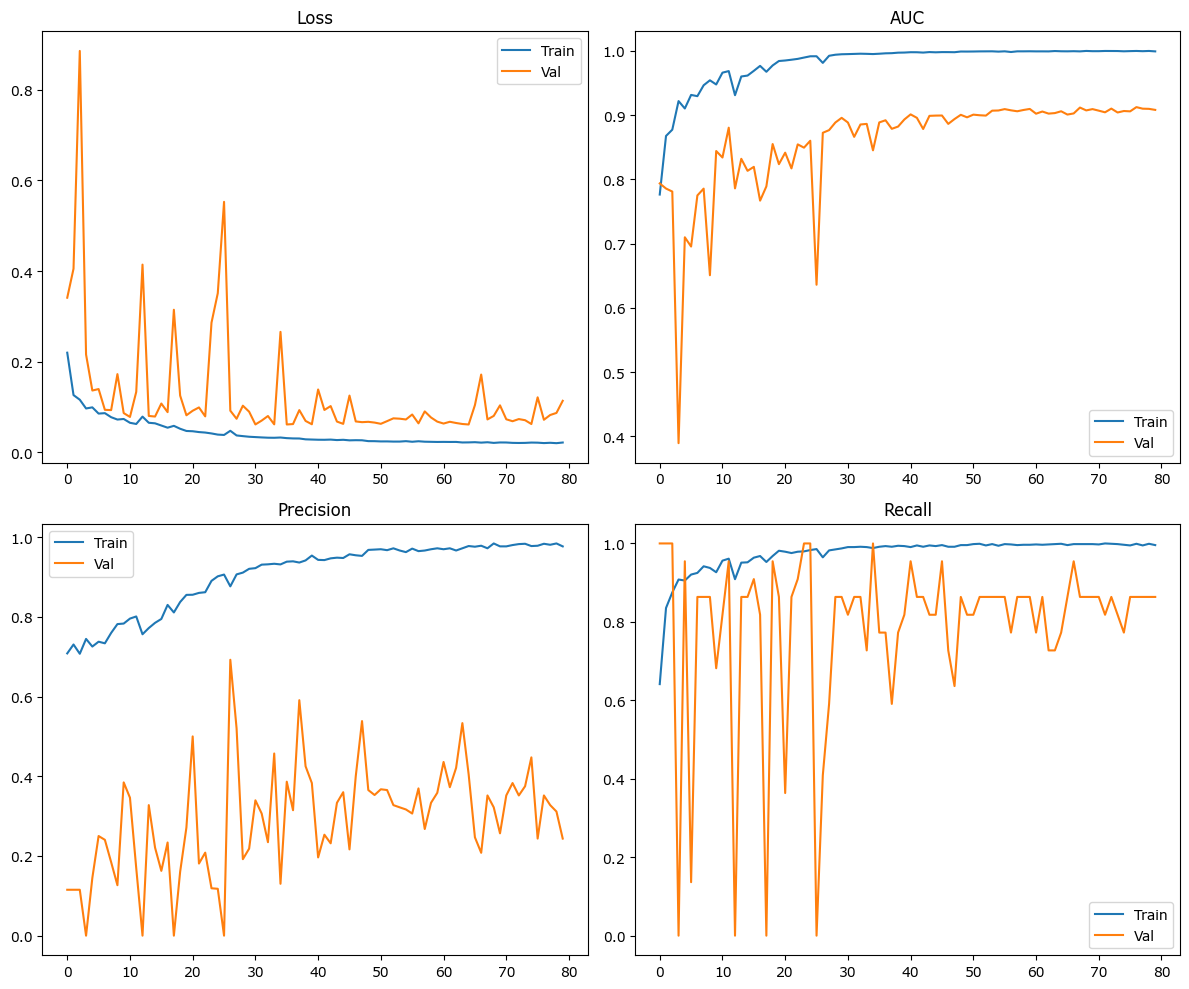

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()

# AUC
axes[0, 1].plot(history.history['auc'], label='Train')
axes[0, 1].plot(history.history['val_auc'], label='Val')
axes[0, 1].set_title('AUC')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Val')
axes[1, 0].set_title('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Val')
axes[1, 1].set_title('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate with threshold optimization
model = keras.models.load_model('best_model_improved.h5', 
                                 custom_objects={'loss': focal_loss(gamma=2.0, alpha=0.75)})

# Get predictions
y_pred_proba = model.predict(testx, verbose=0).flatten()

# Find optimal threshold using validation set
val_pred_proba = model.predict(valx, verbose=0).flatten()
best_f1 = 0
best_threshold = 0.5

for thresh in np.arange(0.1, 0.9, 0.05):
    val_pred = (val_pred_proba > thresh).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(valy, val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Optimal threshold: {best_threshold:.2f} (F1={best_f1:.3f})")

# Apply optimal threshold
y_pred = (y_pred_proba > best_threshold).astype(int)

# Test metrics
test_results = model.evaluate(testx, testy, verbose=0)
print("\nTest Results (threshold=0.5):")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]:.4f}")
print(f"Recall: {test_results[4]:.4f}")

print(f"\nClassification Report (threshold={best_threshold:.2f}):")
print(classification_report(testy, y_pred, target_names=['Healthy', 'Aneurysm']))

# ROC AUC
roc_auc = roc_auc_score(testy, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Optimal threshold: 0.85 (F1=0.682)

Test Results (threshold=0.5):
Loss: 0.0609
Accuracy: 0.8455
AUC: 0.9358
Precision: 0.4111
Recall: 0.8605

Classification Report (threshold=0.85):
              precision    recall  f1-score   support

     Healthy       0.96      0.96      0.96       339
    Aneurysm       0.70      0.65      0.67        43

    accuracy                           0.93       382
   macro avg       0.83      0.81      0.82       382
weighted avg       0.93      0.93      0.93       382

ROC AUC Score: 0.9357


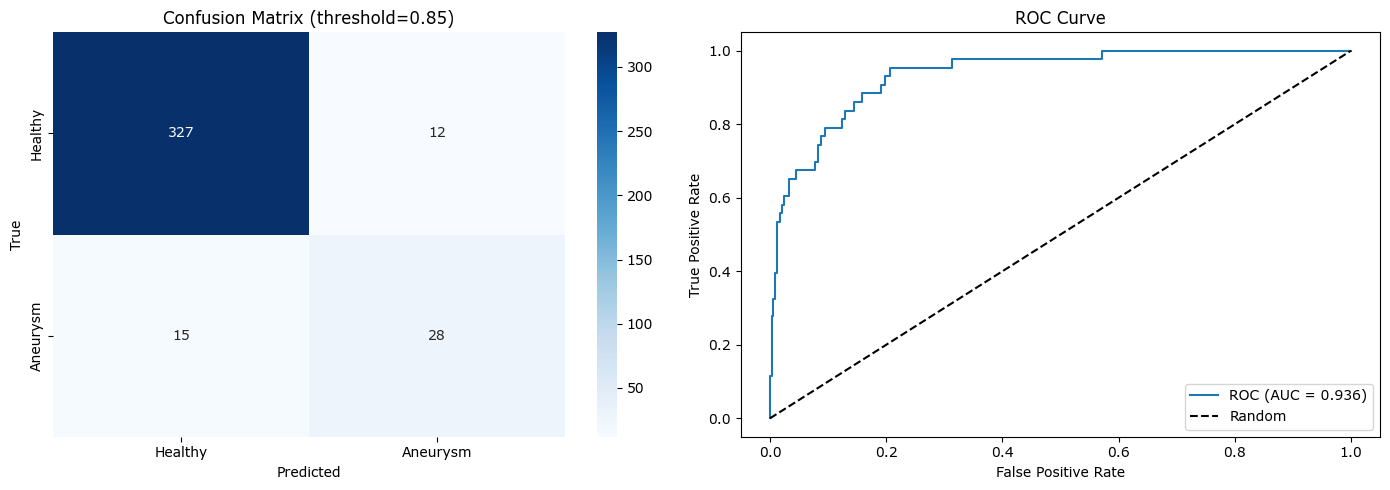

In [ ]:
#Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'],
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix (threshold={best_threshold:.2f})')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, thresholds = roc_curve(testy, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()